#**to do:**

- [define factors](https://happiness-report.s3.amazonaws.com/2021/Appendix1WHR2021C2.pdf)
- put labels on graphs
- graph ladder score over all years for each country



In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read csv files into data frames
df = pd.read_csv("data/world-happiness-report.csv")
df2021 = pd.read_csv("data/world-happiness-report-2021.csv")

In [3]:
# Add column for year on the data set for 2021
df2021['Year'] = 2021

In [4]:
list(df.columns)

['Country name',
 'year',
 'Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

In [5]:
list(df2021.columns)

['Country name',
 'Regional indicator',
 'Ladder score',
 'Standard error of ladder score',
 'upperwhisker',
 'lowerwhisker',
 'Logged GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Ladder score in Dystopia',
 'Explained by: Log GDP per capita',
 'Explained by: Social support',
 'Explained by: Healthy life expectancy',
 'Explained by: Freedom to make life choices',
 'Explained by: Generosity',
 'Explained by: Perceptions of corruption',
 'Dystopia + residual',
 'Year']

In [6]:
# drop unnecessary columns
df2021 = df2021.drop(columns=['Standard error of ladder score','upperwhisker', 'lowerwhisker',
       'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual'], axis=1)
df = df.drop(columns=['Positive affect','Negative affect'], axis=1)

In [7]:
# rename columns so that the data in the two files can be compared with by the same variable names
df2021 = df2021.rename(columns = {'Logged GDP per capita':'Log GDP per capita'} )
df = df.rename(columns= {'year':'Year', 'Life Ladder':'Ladder score', 'Healthy life expectancy at birth' : 'Healthy life expectancy'}) #we assume that healthy life expectancy at birth is the same as healthy life expectancy 

In [8]:
# add regional indicator to data set for 2008-2020
df_with_regions = pd.merge(df, df2021[['Country name','Regional indicator']], on = ['Country name'])
# df_with_regions
df_with_regions["Year"].unique() #does not include 2021

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2007, 2020, 2006, 2005])

In [9]:
# combine data sets to create one data frame for 2008-2021
df_all = pd.concat([df_with_regions, df2021], ignore_index=True).sort_values(by="Country name", ascending=True)
years_list = list(df_all["Year"].unique())
years_list

[2008,
 2019,
 2018,
 2017,
 2016,
 2015,
 2021,
 2013,
 2012,
 2011,
 2010,
 2009,
 2014,
 2020,
 2007,
 2006,
 2005]

In [10]:
# reorder columns
df_all = df_all[['Country name',
                 'Regional indicator',
                 'Year',
                 'Ladder score',
                 'Log GDP per capita',
                 'Healthy life expectancy',
                 'Social support',
                 'Freedom to make life choices',
                 'Generosity',
                 'Perceptions of corruption']]

In [11]:
# add column for time in terms of COVID
def covid_time(row):
    if row["Year"] < 2020:
        return "Pre-COVID"
    else:
        return "Post-COVID"

df_all["COVID time"] = df_all.apply(covid_time, axis=1)
df_all

,Country name,Regional indicator,Year,Ladder score,Log GDP per capita,Healthy life expectancy,Social support,Freedom to make life choices,Generosity,Perceptions of corruption,COVID time
0,Afghanistan,South Asia,2008,3.724,7.370,50.800,0.451,0.718,0.168,0.882,Pre-COVID
11,Afghanistan,South Asia,2019,2.375,7.697,52.400,0.420,0.394,-0.108,0.924,Pre-COVID
10,Afghanistan,South Asia,2018,2.694,7.692,52.600,0.508,0.374,-0.094,0.928,Pre-COVID
9,Afghanistan,South Asia,2017,2.662,7.697,52.800,0.491,0.427,-0.121,0.954,Pre-COVID
8,Afghanistan,South Asia,2016,4.220,7.697,53.000,0.559,0.523,0.042,0.793,Pre-COVID
...,...,...,...,...,...,...,...,...,...,...,...
1873,Zimbabwe,Sub-Saharan Africa,2008,3.174,7.461,44.140,0.843,0.344,-0.090,0.964,Pre-COVID
1871,Zimbabwe,Sub-Saharan Africa,2006,3.826,7.711,41.580,0.822,0.431,-0.076,0.905,Pre-COVID
2033,Zimbabwe,Sub-Saharan Africa,2021,3.145,7.943,56.201,0.750,0.677,-0.047,0.821,Post-COVID
1877,Zimbabwe,Sub-Saharan Africa,2012,4.955,7.983,49.540,0.896,0.470,-0.103,0.859,Pre-COVID


In [13]:
list(df_all.columns)

['Country name',
 'Regional indicator',
 'Year',
 'Ladder score',
 'Log GDP per capita',
 'Healthy life expectancy',
 'Social support',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'COVID time']

In [ ]:
# average ladder score by region
df_all.groupby('Regional indicator')['Ladder score'].mean().plot.barh()

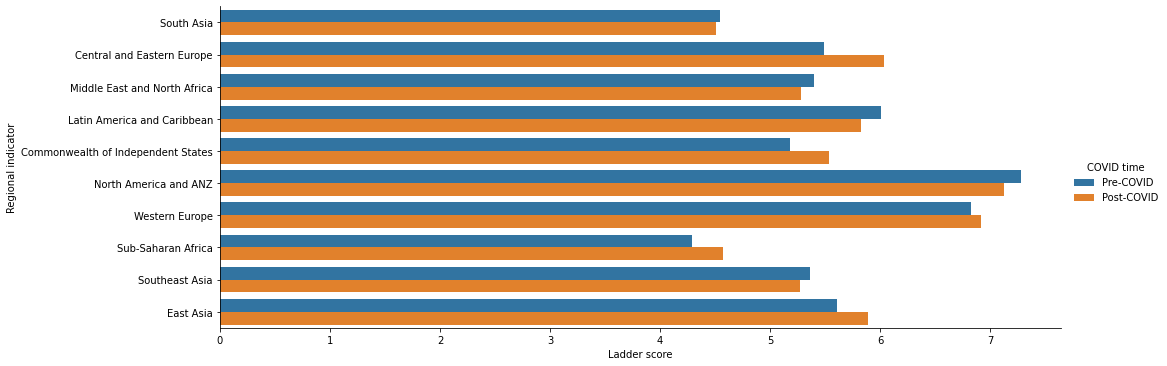

In [26]:
# plot pre-covid and post-covid on same graph as two different bars
covid_plot = sns.catplot(x="Ladder score", y="Regional indicator", hue="COVID time", data=df_all, kind="bar", ci=None, height=5, aspect=3)

In [ ]:
# create pivot table for countries (should probably delte, too much going on)
df_pivot_country = df_all.pivot("Year", "Country name", "Ladder score")
sns.lineplot(data=df_pivot_country)

In [ ]:
# create pivot table for regions
df_region = df_all.groupby(['Regional indicator', 'Year'])['Ladder score'].mean().to_frame().reset_index()

df_pivot_region = df_region.pivot("Year", "Regional indicator", "Ladder score")
sns.lineplot(data=df_pivot_region)

# need to move key

In [ ]:
# sort countries by average ladder score over all years
df_all_ladder = df_all.groupby('Country name')['Ladder score'].mean().sort_values(ascending=False)
df_all_ladder

In [ ]:
# compare two factors
mydata = df_all[["Social support", "Ladder score"]].dropna(how="any")
vals = mydata.values
plt.scatter(vals[:, 0], vals[:, 1])
plt.xlabel("Social support")
plt.ylabel("Ladder score")

In [ ]:
# table of values for correlation
df_all.corr()

In [ ]:
#heat map for correlation
f,ax=plt.subplots(figsize=(8,8))
corrMatrix = df_all.corr()
Heatmap = sns.heatmap(corrMatrix, annot=True, linewidth=.5,fmt='.2f',ax=ax)
plt.show()


In [ ]:
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# from pandas_profiling import ProfileReport

In [ ]:
# my_report = ProfileReport(df_all, title="My Report - Testing", html={'style':{'full width':True}})
# my_report.to_notebook_iframe()
# my_report.to_file(output_file="My Report - Testing.html")